<a href="https://colab.research.google.com/github/hydrationn/Machine-DeepLearning/blob/main/DeepLearning/lab/20240516_%EC%8B%A4%EC%8A%B505_Sequence_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import package

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# GPU/CPU setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

cuda


In [4]:
# import dataset

import yfinance as yf

aapl = yf.download('AAPL', start = '2019-01-01', end = '2023-12-31')
aapl

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793781,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029228,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481918,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402946,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077831,164101200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542816,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


<Axes: xlabel='Date'>

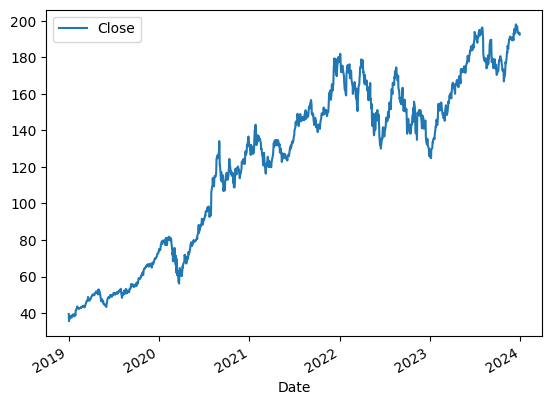

In [5]:
# import dataset

import pandas as pd

df_aapl = pd.DataFrame(aapl['Close'])
df_aapl.plot()

In [6]:
# Data preprocessing

from sklearn.preprocessing import MinMaxScaler

data_aapl = df_aapl.values
scaler = MinMaxScaler(feature_range=(0,1))
data_aapl = scaler.fit_transform(data_aapl)

train_ratio = 0.8
split = int(train_ratio*len(data_aapl))
aapl_train = data_aapl[:split, :]
aapl_test = data_aapl[split:, :]

print(aapl_train.shape)
print(aapl_test.shape)

(1006, 1)
(252, 1)


In [11]:
# Data preprocessing
sequence_length = 10

x_train, y_train = [], []
for i in range(sequence_length, len(aapl_train)):
  x_train.append(aapl_train[i-sequence_length:i,0])
  y_train.append(aapl_train[i,0])

x_test, y_test = [], []
for i in range(sequence_length, len(aapl_test)):
  x_test.append(aapl_test[i-sequence_length:i,0])
  y_test.append(aapl_test[i,0])

x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train = torch.FloatTensor(x_train)
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train = torch.FloatTensor(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test = torch.FloatTensor(x_test);
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = torch.FloatTensor(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([996, 10, 1]) torch.Size([996, 1]) torch.Size([242, 10, 1]) torch.Size([242, 1])


In [12]:
# Batch generation

batch_size = 20

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [39]:
# Model

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self_sequence_length = sequence_length
    self.num_layers = num_layers
    self.device = device
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid())

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)

    return out

In [40]:
# Model

input_size = 1
num_layers = 2
hidden_size = 5

model = RNN(input_size=input_size, hidden_size=hidden_size, sequence_length=sequence_length, num_layers=num_layers, device=device).to(device)
model

RNN(
  (rnn): RNN(1, 5, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [41]:
# Hyperparameters
num_epochs = 200
learning_rate = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# Model Train

loss_list = []

for epoch_num in range(num_epochs):
  average_cost = 0

  for batch_idx, (x_data, y_label) in enumerate(train_loader):
    num_of_mini_batch = len(train_loader)
    x_data = x_data.to(device)
    label = y_label.to(device)

    optimizer.zero_grad()
    y_predict = model(x_data)
    loss = criterion(y_predict, label)
    loss.backward()
    optimizer.step()

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

  print("Epoch {} Loss {:.5f}".format((epoch_num+1), average_cost))

Epoch 1 Loss 0.05021
Epoch 2 Loss 0.13869
Epoch 3 Loss 0.16035
Epoch 4 Loss 0.07612
Epoch 5 Loss 0.05347
Epoch 6 Loss 0.02462
Epoch 7 Loss 0.12977
Epoch 8 Loss 0.22946
Epoch 9 Loss 0.10739
Epoch 10 Loss 0.08361
Epoch 11 Loss 0.13873
Epoch 12 Loss 0.22556
Epoch 13 Loss 0.40805
Epoch 14 Loss 0.27747
Epoch 15 Loss 0.01286
Epoch 16 Loss 0.29231
Epoch 17 Loss 0.01940
Epoch 18 Loss 0.12366
Epoch 19 Loss 0.27615
Epoch 20 Loss 0.10803
Epoch 21 Loss 0.30230
Epoch 22 Loss 0.27963
Epoch 23 Loss 0.02413
Epoch 24 Loss 0.26742
Epoch 25 Loss 0.03217
Epoch 26 Loss 0.13948
Epoch 27 Loss 0.29712
Epoch 28 Loss 0.25059
Epoch 29 Loss 0.18017
Epoch 30 Loss 0.00667
Epoch 31 Loss 0.01006
Epoch 32 Loss 0.00584
Epoch 33 Loss 0.00567
Epoch 34 Loss 0.00524
Epoch 35 Loss 0.00501
Epoch 36 Loss 0.00485
Epoch 37 Loss 0.00475
Epoch 38 Loss 0.00468
Epoch 39 Loss 0.00462
Epoch 40 Loss 0.00458
Epoch 41 Loss 0.00455
Epoch 42 Loss 0.00452
Epoch 43 Loss 0.00451
Epoch 44 Loss 0.00449
Epoch 45 Loss 0.00449
Epoch 46 Loss 0.004

In [46]:
# Validation

with torch.no_grad():
  num_total_data = 0
  correct = 0
  for batch_idx, (data, labels) in enumerate(test_loader):
    num_of_mini_batch = len(test_loader)

    data = data.to(device)
    labels = labels.to(device)
    outputs = model(data)
    loss = criterion(outputs, labels)

    average_cost = average_cost + (loss.item()/num_of_mini_batch)
    loss_list.append(loss)

print("Test Loss {:5f}".format(average_cost))

Test Loss 0.045282


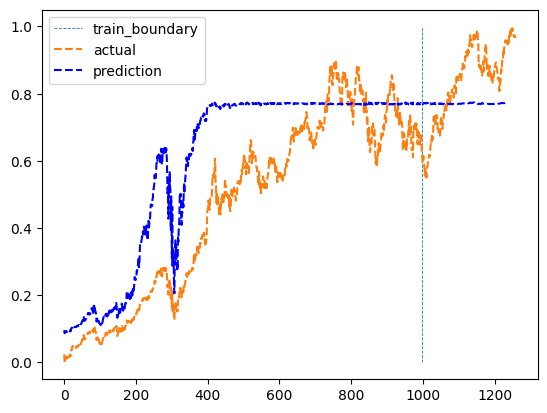

In [47]:
# plot

with torch.no_grad():
  train_pred = []
  test_pred = []

  for batch_idx, (x_data, y_label) in enumerate(train_loader):
    x_data = x_data.to(device)
    label = y_label.to(device)
    y_predict = model(x_data)
    train_pred += y_predict.cpu().numpy().tolist()

  for batch_idx, (x_data, y_label) in enumerate(test_loader):
    x_data = x_data.to(device)
    label = y_label.to(device)
    y_predict = model(x_data)
    test_pred += y_predict.cpu().numpy().tolist()

total = train_pred + test_pred
plt.figure()
plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6)
plt.plot(data_aapl, '--')
plt.plot(total, 'b--')
plt.legend(['train_boundary', 'actual', 'prediction'])
plt.show()